In [81]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler as Sampler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn, optim

from sklearn import metrics

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

In [49]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Task 1

## Part 1:

### Download Data

In [149]:
transform = transforms.Compose([ToTensor(), transforms.Normalize((0,),(1,),)])

In [150]:
train = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True, train=True, transform=transform)
test = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True, train=False, transform=transform)

### Prepare Data

In [151]:
N = len(train)
indecies = np.arange(0,N)
train_size = int(np.floor(.2*N))
np.random.shuffle(indecies)

train_loader = DataLoader(train, sampler=Sampler(indecies[:train_size]), batch_size=64)
val_loader   = DataLoader(train, sampler=Sampler(indecies[train_size:]), batch_size=64)
test_loader  = DataLoader(test, batch_size=64)

### Visualize Data

In [152]:
preview = {}
i=0
while len(preview) < 10:
    x,y = train[i]
    preview[y] = x
    i+=1

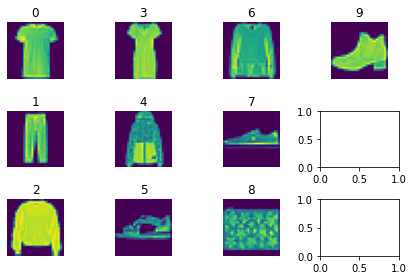

In [153]:
fig, Ax = plt.subplots(3,4)
for i in range(10):
    row = i//3
    col = i% 3
    ax = Ax[col][row]
    ax.imshow(preview[i][0])
    ax.set_title(i)
    ax.axis('off')
fig.tight_layout()

### The Model

In [154]:
class FMNet(nn.Module):
    def __init__(self):
        super(FMNet, self).__init__()
        #d = 28*28
        num_classes = 10
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Flatten(),
            nn.Linear(800, 500),
            nn.ReLU(),

            nn.Linear(500, num_classes),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x):
        
        logits = self.stack(x)
        return logits

In [155]:
train[0][0].shape

torch.Size([1, 28, 28])

### Training the model

In [156]:
def train_epoch(model, criterion, optimizer, trainloader):
   
    #size = len(trainloader.dataset)
    
    for batchnum, (X,y) in enumerate(trainloader):
        model.train()
        optimizer.zero_grad()
        
        yhat = model(X)
        loss = criterion(yhat, y)
        

        loss.backward()
        optimizer.step()

In [157]:
def validate(model, criterion, valloader):
    model.eval()
    
    size = len(valloader.dataset)
    num_batches = len(valloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for X, y in valloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += ( yhat.argmax(1) == y).type(torch.float).sum().item()
            
    loss = test_loss / num_batches
    accuracy = correct / size
    
    return (loss, accuracy)

In [161]:
model = FMNet().to('cpu')
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

In [162]:
epochs = 50
error = np.empty((epochs,2))

In [163]:
for epoch in tqdm(range(epochs)):
    
    train_epoch(model, crit, optimizer, train_loader)
    
    loss, accuracy = validate(model, crit, test_loader )

    print(f"Epoch {epoch+1}\n-------------------------------")
    print(f"Test Error: \n Accuracy: {(accuracy*100):>0.1f}%, Avg loss: {loss:>8f} \n")
    error[epoch] = [accuracy,loss]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.591394 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.523092 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.439282 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.487055 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.393189 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.386110 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.365891 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.405393 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.399179 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.349612 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 86.7%, Avg los

### Evaluation

In [42]:
def confusion_matrix(model, dataloader, num_classes):
    CM = np.zeros((num_classes,num_classes))
    model.eval()
    labels = [i for i in range(num_classes)]
    for x,y in dataloader:
        yhat = model(x)
        
        CM += metrics.confusion_matrix(y, yhat.argmax(dim=1), labels=labels)
        
    return CM

In [164]:
confusion_matrix(model, test_loader, 10)

array([[820.,   1.,  15.,  24.,   3.,   3., 120.,   1.,  12.,   1.],
       [  5., 972.,   1.,  14.,   1.,   0.,   4.,   0.,   3.,   0.],
       [ 18.,   2., 828.,  10.,  58.,   1.,  82.,   0.,   1.,   0.],
       [ 18.,   5.,   9., 895.,  29.,   0.,  39.,   0.,   3.,   2.],
       [  0.,   1.,  73.,  30., 834.,   0.,  62.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 952.,   0.,  24.,   1.,  23.],
       [106.,   1.,  74.,  26.,  74.,   2., 701.,   0.,  16.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  15.,   0., 960.,   0.,  25.],
       [  8.,   1.,   4.,   7.,   6.,   2.,  13.,   4., 955.,   0.],
       [  0.,   0.,   0.,   0.,   1.,   7.,   0.,  31.,   0., 961.]])

In [165]:
loss, accuracy = validate(model, crit, test_loader)
print(f"Test Error: \n Accuracy: {(accuracy*100):>0.1f}%, Avg loss: {loss:>8f} \n")

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.875472 



## Part 2

In [166]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Resize(256),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),        
        transforms.Resize(256)
        
    ]) }

In [167]:
image_datasets = {
    'train': datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True, train=True, transform=data_transforms['train']),
    'val': datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True, train=False, transform=data_transforms['val'])
}

In [ ]:
indices = np.arange(len(image_datasets['train']))
np.random.shuffle( indices )
train_subset = Subset(image_datasets['train'], indices[0:1000])

indices = np.arange(len(image_datasets['val']))
np.random.shuffle( indices )
val_subset = Subset(image_datasets['val'], indices[0:100])

In [168]:
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64,
                                             shuffle=True),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=64,
                                             shuffle=True)
              }
                

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val'] }

In [169]:
resnet = models.resnet18(pretrained=True)

In [170]:
for param in resnet.parameters():
    param.requires_grad = False
classes = 10
    
resnet.fc = nn.Linear(resnet.fc.in_features, classes)
resnet = resnet.to('cpu')

In [171]:
crit = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=.001, momentum=.9)
lr_decay = lr_scheduler.StepLR(optimizer, step_size=3, gamma=.1)

In [172]:
def train_transfer(model, criterion, optimizer, trainloader):
    model.train()
    
    for x,y in trainloader:
        x = x.to('cpu')
        y = y.to('cpu')
        
        optimizer.zero_grad()
        
        yhat = model(x)
        
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()    

In [173]:
epochs = 25
for epoch in tqdm(range(epochs)):
    
    train_transfer(resnet, crit, optimizer, dataloaders['train'])
    
    loss, accuracy = validate(resnet, crit, dataloaders['val'] )
    print(f"Epoch {epoch+1}\n-------------------------------")
    print(f"Test Error: \n Accuracy: {(accuracy*100):>0.1f}%, Avg loss: {loss:>8f} \n")
    error[epoch] = [accuracy,loss]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.560295 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.505431 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.471418 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.457832 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.444824 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.434023 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.433351 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.426198 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.431968 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.417368 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 85.2%, Avg los

KeyboardInterrupt: 

There was no error. I just stopped it earlier than planned.

In [225]:
validate(resnet, crit, dataloaders['val'] )

(0.4088193668871169, 0.8545)

The transfer learning model performs slightly worse than the model from Part 1.

### Part 3

In [210]:
class Rotator:
    def __init__(self, angle, prob):
        self.angle = angle
        self.p = prob
    def __call__(self, image):
        if np.random.random() < self.p:
            return transforms.functional.rotate(image, self.angle)
        else:
            return transforms.functional.rotate(image, 0)

In [218]:
train_transform = transforms.Compose([ToTensor(), transforms.Normalize((0,),(1,),), Rotator(90, .20)])
transform = transforms.Compose([ToTensor(), transforms.Normalize((0,),(1,),)])

In [219]:
train_aug = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True, train=True, transform=train_transform)
test_aug = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True, train=False, transform=transform)

In [220]:
train_loader_aug = DataLoader(train_aug, sampler=Sampler(indecies[:train_size]), batch_size=64)
val_loader_aug   = DataLoader(train_aug, sampler=Sampler(indecies[train_size:]), batch_size=64)
test_loader_aug  = DataLoader(test_aug, batch_size=64)

In [221]:
model_aug = FMNet().to('cpu')

In [222]:
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=.001)

In [223]:
epochs = 50
error_aug = np.empty((epochs,2))

In [224]:
for epoch in tqdm(range(epochs)):
    
    train_epoch(model_aug, crit, optimizer, train_loader_aug)
    
    loss, accuracy = validate(model_aug, crit, test_loader_aug )

    print(f"Epoch {epoch+1}\n-------------------------------")
    print(f"Test Error: \n Accuracy: {(accuracy*100):>0.1f}%, Avg loss: {loss:>8f} \n")
    error_aug[epoch] = [accuracy,loss]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 73.8%, Avg loss: 0.707608 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.559986 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.471352 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.478242 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.430874 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.400614 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.408932 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.376264 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.372293 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.393828 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 87.3%, Avg los

Data augmentation did not alter the performance of the model.